<a href="https://colab.research.google.com/github/haleyrx/qe_project/blob/main/transquest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Prep**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
%cd gdrive/MyDrive/CS7643

/content/gdrive/MyDrive/CS7643


In [ ]:
# ! git clone https://2726c3be06d254f6092d9413236205338399aed0@github.com/haleyrx/qe_project

fatal: destination path 'qe_project' already exists and is not an empty directory.


In [4]:
!ls

colab_setup.ipynb  CS7643_HW4  qe_project


In [8]:
%cd qe_project
# ! git pull

/content/gdrive/MyDrive/CS7643/qe_project


In [5]:
!pip install sentencepiece
!pip install transformers==3


In [1]:
!nvidia-smi

Mon Apr 19 16:08:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
%pwd

'/content'

### Set up parameters

In [13]:
SEED = 777
RESULT_FILE = 'ne-en_result.tsv'
METRICS_FILE = 'ne-en_metrics.txt'
BEST_MODEL_FILE = 'ne-en_best_model.bin'
MODEL_TYPE = 'xlmroberta'
MODEL_NAME = 'xlm-roberta-large'
TRAIN_DATA = 'ne-en/train.neen.df.short.tsv'
DEV_DATA = 'ne-en/dev.neen.df.short.tsv'
TEST_DATA = 'ne-en/test20.neen.df.short.tsv'

# Model parameters
args = {
    'data_dir': './data/',
    'output_dir': './results/',
    'best_model_dir': './best_models/',
  
    'max_seq_length': 128,
    'train_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'eval_batch_size': 8,
    'num_train_epochs': 3,
    'weight_decay': 0,
    'learning_rate': 1e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.1,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,
    "manual_seed": SEED,

}

In [14]:
# Get relevant paths

import os 

train_path = os.path.join(args['data_dir'], TRAIN_DATA)
dev_path = os.path.join(args['data_dir'], DEV_DATA)
test_path = os.path.join(args['data_dir'], TEST_DATA)
best_model_path = os.path.join(args['best_model_dir'], BEST_MODEL_FILE)
results_path = os.path.join(args['output_dir'], RESULT_FILE)
metrics_path = os.path.join(args['output_dir'], METRICS_FILE)


In [15]:
train_path

'./data/ne-en/train.neen.df.short.tsv'

## Read in Data

In [21]:
import csv
import pandas as pd

# function adapted from https://github.com/TharinduDR/
def read_file(path, index='index'):
    indices = []
    originals = []
    translations = []
    z_means = []
    with open(path, mode='r', encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t', quoting=csv.QUOTE_NONE)
        for row in reader:
            indices.append(row[index])
            originals.append(row['original'])
            translations.append(row['translation'])
            z_means.append(float(row['z_mean']))

    return pd.DataFrame(
        {'index': indices,
         'original': originals,
         'translation': translations,
         'z_mean': z_means
         })

In [22]:
# import pandas as pd
# df_train = pd.read_csv(train_path, sep='\t', encoding='utf-8-sig')
df_train = read_file(train_path)
train = df_train[['original', 'translation', 'z_mean']]
train.head()

,original,translation,z_mean
0,रैका भन्ने शब्दबाट रैकावर/रैका तप्पा नामाकरण भ...,Raikawar / Raika Tappa is named from the word ...,0.853093
1,यो कुरा हनुमानको पादपीठमा कुँदिएको अभिलेखबाट थ...,It is known from a recipe that is cooked in th...,-0.431285
2,प्रस्तुत काव्यमा छन्दशास्त्रीय नियमअनुसार ‘शिख...,According to the rosary rules in the present c...,-1.465843
3,सिन्धुलीमाढी शहरमा झन्डै ४० हजार मानीस बसोबास ...,Maanis live nearly 40 thousand in the city of ...,-0.516619
4,"भगवान् शिवको हातमा रहेको त्रिशुल, बज्र आयुध नै...","The Tree, which is in the hands of the goddess...",-1.058211


In [23]:
# df_dev = pd.read_csv(dev_path,sep='\t')
df_dev = read_file(dev_path)
dev = df_dev[['original', 'translation', 'z_mean']]
dev.head()

,original,translation,z_mean
0,बौद्धहरु गुम्बा वा देवतालाई परिक्रमा गर्दा दाह...,"Bonpos, if the inhabitants are gamblers or god...",-0.983843
1,त्यसै गरी वेदका उपवेदहरू निम्न अनुसार छन्ः ऋग्...,So far the subsidiaries of the altar are as fo...,0.333005
2,"आधारभूत संरचनामा सुधारको बेला, यो उपेक्षा गरीर...","During improvements to the basic structure, it...",0.708585
3,दाजुभाइले निस्रोमा टक्राएको चामल र विभिन्न खान...,The brothers carry a trapped chamber and vario...,-0.379051
4,फिल्म र कुनिजले मिश्रित प्रतिक्रिया पाए पनि चल...,Although the film and kuniz received a mixed r...,2.510893


In [24]:
# df_test = pd.read_csv(test_path,sep='\t')
df_test = read_file(test_path)
test = df_test[['original', 'translation', 'z_mean']]
test.head()

,original,translation,z_mean
0,कोशी अन्चल अस्पतालका साथै केही सामुदायीक तथा ...,Some community and private health institutions...,1.125492
1,विक्रम सम्वत२०३६ पछिको कथालेखन काललाई समसामयिक...,While the storytelling calculations after the ...,-0.561816
2,"तथापी, उनले आफ्नो अधिकांश आविष्कारहरू बाहिर प्...","Nevertheless, many stole his inventions becaus...",0.179027
3,यस्तै अङ्गीरसमा करुण रसको कुरा उल्लेख नगर्नाले...,"Similar to Angirus, not mentioning the Caribbe...",-0.194699
4,"पछिल्लो समयमा सारावली, मानसागरी, जातकतत्व, भृग...","In later times, there have been sufficient chr...",0.363625


In [15]:
train = train.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
dev = dev.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
test = test.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()

### Use sklearn to preprocess z-scores


In [16]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()


def fit(df, label):
    x = df[[label]].values.astype(float)
    x_scaled = min_max_scaler.fit_transform(x)
    df[label] = x_scaled
    return df


def un_fit(df, label):
    x = df[[label]].values.astype(float)
    x_unscaled = min_max_scaler.inverse_transform(x)
    df[label] = x_unscaled
    return df

In [17]:
train = fit(train, 'labels')
dev = fit(dev, 'labels')

### Import packages

In [18]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import XLMRobertaConfig, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, XLMRobertaModel
import torch

import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [19]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Download pretrained model

In [20]:
# Initialize config, tokenizer, and pretrained model
MODEL_CLASSES = {'xlmroberta': (XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer)}

config_class, model_class, tokenizer_class = MODEL_CLASSES[MODEL_TYPE]

config = config_class.from_pretrained(MODEL_NAME, num_labels=1)
tokenizer = tokenizer_class.from_pretrained(MODEL_NAME)

### Create data loader and load batches

In [21]:
class TranslationDataset(Dataset):
  def __init__(self, text_a, text_b, labels, tokenizer, max_len):
    self.text_a = text_a
    self.text_b = text_b
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text_a)

  def __getitem__(self, item):
    original = str(self.text_a[item])
    translation = str(self.text_b[item])
    label = float(self.labels[item])
    encoding = self.tokenizer.encode_plus(
      original,
      translation,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'original_text': original,
      'translation_text': translation,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.float32)
    }

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TranslationDataset(
    text_a=df.text_a.to_numpy(),
    text_b=df.text_b.to_numpy(),
    labels=df.labels.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [23]:
train_data_loader = create_data_loader(train, tokenizer, args['max_seq_length'], args['train_batch_size'])
dev_data_loader = create_data_loader(dev, tokenizer, args['max_seq_length'], args['train_batch_size'])
test_data_loader = create_data_loader(test, tokenizer, args['max_seq_length'], args['train_batch_size'])

In [24]:
data = next(iter(test_data_loader))
data.keys()

dict_keys(['original_text', 'translation_text', 'input_ids', 'attention_mask', 'label'])

In [25]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])


In [26]:
print(data['original_text'][0])
print(data['label'][0].numpy())

Jocurile de oferă noi provocări pentru IA în domeniul teoriei jocurilor.
0.3482595


### Define MonoTransQuest Model

In [27]:
class MonoTransQuest(nn.Module):

  def __init__(self, config):
    super(MonoTransQuest, self).__init__()
    self.model = model_class.from_pretrained(MODEL_NAME)
    self.dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.out_proj = nn.Linear(config.hidden_size, config.num_labels)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    sequence_output = outputs[0]
    x = sequence_output[:, 0, :]  # take <s> token (equiv. to [CLS])
    x = self.dropout(x)
    x = self.dense(x)
    x = torch.tanh(x)
    x = self.dropout(x)
    x = self.out_proj(x)

    return torch.sigmoid(x)

In [28]:
model = MonoTransQuest(config)
model = model.to(device)

### Training

In [29]:
import math

t_total = len(train_data_loader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
warmup_steps = math.ceil(t_total * args['warmup_ratio'])
args['warmup_steps'] = warmup_steps if args['warmup_steps'] == 0 else args['warmup_steps']

optimizer = AdamW(model.parameters(), lr=args['learning_rate'], eps=args['adam_epsilon'])
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=args['warmup_steps'], 
  num_training_steps=t_total
)

loss_fn = nn.MSELoss().to(device)

In [30]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = torch.unsqueeze(d["label"], 1)
    labels = labels.float()
    labels = labels.to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss = loss_fn(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=args['max_grad_norm'])
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return np.mean(losses)

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = torch.unsqueeze(d["label"], 1)
      labels = labels.float()
      labels = labels.to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      loss = loss_fn(outputs, labels)
      losses.append(loss.item())
  return np.mean(losses)

In [32]:
%%time

history = defaultdict(list)
best_loss = float('inf')
for epoch in range(args['num_train_epochs']):
  print(f'Epoch {epoch + 1}/{args["num_train_epochs"]}')
  print('-' * 10)
  train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss}')
  val_loss = eval_model(
    model,
    dev_data_loader,
    loss_fn,
    device,
    len(df_dev)
  )
  print(f'Val   loss {val_loss}')
  print()
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  if val_loss < best_loss:
    torch.save(model.state_dict(), best_model_path)
    best_loss = val_loss

Epoch 1/3
----------
Train loss 0.04231612471926302
Val   loss 0.02129944542365704

Epoch 2/3
----------
Train loss 0.019759695528904164
Val   loss 0.02346855099312961

Epoch 3/3
----------
Train loss 0.013956073232169935
Val   loss 0.017781193901196514

CPU times: user 11min 20s, sys: 7min 48s, total: 19min 8s
Wall time: 20min 1s


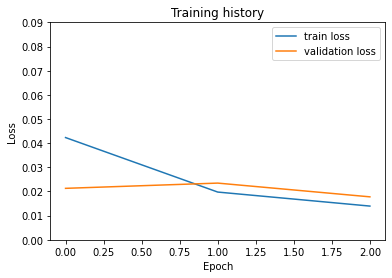

In [33]:
# Plot graphs 
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.09]);

### Generating predictions and metrics

In [ ]:
# Load pretrained model
model = MonoTransQuest(config)
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

In [34]:
# Function to calculate predictions on test set
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  originals = []
  translations = []

  with torch.no_grad():
    for d in data_loader:
      ori = d["original_text"]
      trans = d["translation_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = torch.unsqueeze(d["label"], 1)
      labels = labels.float()
      labels = labels.to(device)
      preds = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      originals.extend(ori)
      translations.extend(trans)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return originals, translations, predictions, real_values

In [35]:
# Get predictions 
originals, translations, predictions, real_values = get_predictions(model,test_data_loader)

preds = predictions.numpy().squeeze()
labels = real_values.numpy().squeeze()
original = np.array(originals)
translation = np.array(translations)

df_results = pd.DataFrame()
df_results['original'] = original
df_results['translation'] = translation
df_results['z_mean'] = labels
df_results['pred_zscore'] = preds

df_results = un_fit(df_results, 'pred_zscore')

df_results.head(30)

,original,translation,z_mean,pred_zscore
0,Jocurile de oferă noi provocări pentru IA în d...,Games provide new challenges for IA in the are...,0.348260,0.774597
1,Germanii au pierdut șansa distrugerii flotei d...,The Germans have lost the chance of destroying...,0.772494,0.833085
2,Nu toate lucrările lui Kafka sunt relatate îns...,Not all the work of Kafka is reported to the t...,0.723016,0.784927
3,Nu a menționat absolut nimic privind despăgubi...,He said absolutely nothing about war compensat...,0.802019,0.829134
4,"Satul Livadia nu mai are un învățător stabil, ...","The Livadia village no longer has a permanent,...",-0.278231,-0.369657
5,"Volscii, ernicii și equii au aderat la tratatu...","Volunteers, Eritreans and equii acceded to Spu...",-1.045913,-0.953594
6,Istoria evreilor Istoria Palestinei Conferința...,History of the Jews of Palestine Peace Confere...,0.409728,0.227077
7,Meciul fără reguli poate fi disputat între doi...,The machine without rules can be disputed betw...,-0.905103,-0.916730
8,Costa Blanca este foarte bine cunoscuta pentru...,Costa Blanca is well-known for her bland clima...,0.009572,0.518376
9,Mandatul de guvernator al lui Cezar a fost ext...,Cezar's term of office as Governor has been ex...,0.567059,0.827661


In [36]:
# Get evaluation metrics
pearson, _ = stats.pearsonr(df_results['pred_zscore'], df_results['z_mean'])
rmse = mean_squared_error(df_results['z_mean'], df_results['pred_zscore'], squared=False)
mae = mean_absolute_error(df_results['z_mean'], df_results['pred_zscore'])
print("Pearson: {}".format(pearson))
print("RMSE: {}".format(rmse))
print("MAE: {}".format(mae))


Pearson: 0.8756013395476996
RMSE: 0.4603537312381035
MAE: 0.32472268850150554


In [37]:
# Save predictions to tsv
df_results.to_csv(results_path, sep = '\t', index=False)